c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


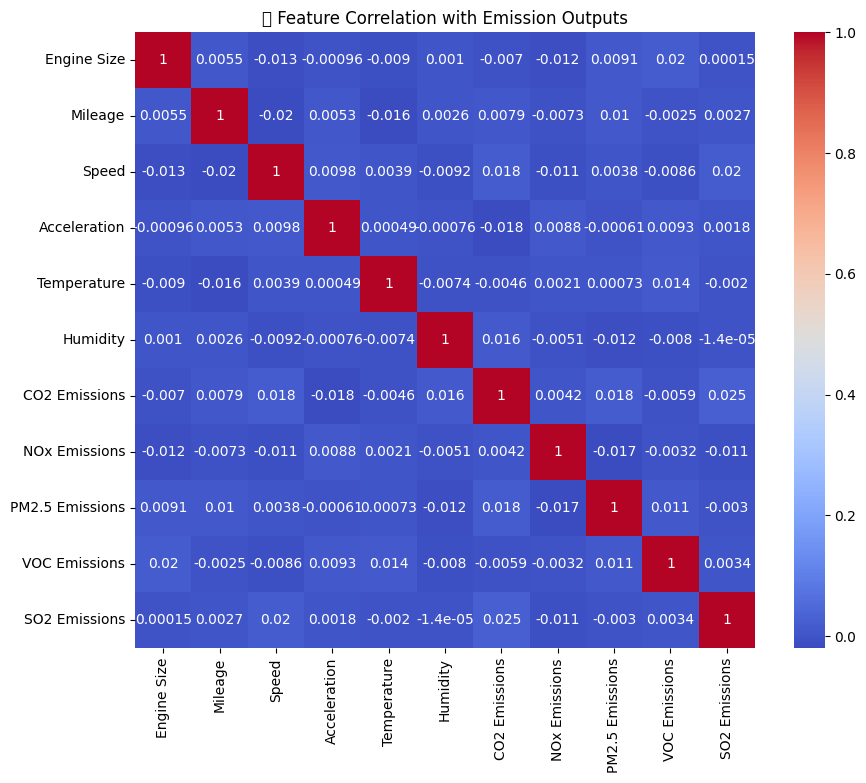

In [3]:
import pandas as pd
data = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\CI LAB\\engine_fault_system\\data\\vehicle_emission_dataset.csv")
corr = data[['Engine Size', 'Mileage', 'Speed', 'Acceleration', 'Temperature', 'Humidity',
             'CO2 Emissions', 'NOx Emissions', 'PM2.5 Emissions', 'VOC Emissions', 'SO2 Emissions']].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("🔍 Feature Correlation with Emission Outputs")
plt.show()

In [10]:
# ==========================================
# 🚀 Synthetic Vehicle Emission Dataset v3
# Realistic emission patterns + Low/Medium/High classification
# ==========================================

import numpy as np
import pandas as pd

# -----------------------------------------------------
# Step 1: Load base dataset
# -----------------------------------------------------
data = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\CI LAB\\engine_fault_system\\data\\vehicle_emission_dataset.csv")
np.random.seed(42)

# -----------------------------------------------------
# Step 2: Define fuel and road emission intensity factors
# -----------------------------------------------------
fuel_factor = {
    'Petrol': 1.0,
    'Diesel': 1.25,
    'Hybrid': 0.7,
    'Electric': 0.1
}
road_factor = {
    'Highway': 1.0,
    'City': 1.1,
    'Rural': 0.9
}

fuel_mult = data['Fuel Type'].map(fuel_factor).fillna(1)
road_mult = data['Road Type'].map(road_factor).fillna(1)

# -----------------------------------------------------
# Step 3: Generate realistic emission values
# -----------------------------------------------------

# CO₂ — dominant contributor, scales with engine size, speed, and fuel
data['CO2 Emissions'] = (
    (28 * data['Engine Size'] +
     0.009 * data['Mileage'] +
     1.4 * data['Speed'] +
     0.7 * data['Acceleration']) *
    fuel_mult * road_mult +
    np.random.normal(5, 7, len(data))
)

# NOₓ — depends on combustion temperature and engine size
data['NOx Emissions'] = (
    (0.5 * data['Engine Size'] +
     0.18 * data['Temperature'] +
     0.22 * data['Acceleration'] +
     0.05 * data['Speed']) *
    fuel_mult * 0.8 +
    np.random.normal(0.2, 0.3, len(data))
)

# PM2.5 — sensitive to humidity and load
data['PM2.5 Emissions'] = (
    (0.025 * data['Acceleration'] +
     0.015 * data['Temperature'] -
     0.008 * data['Humidity']) *
    fuel_mult * 1.5 +
    np.random.normal(0.1, 0.04, len(data))
)

# VOC — volatile organics, linked to speed and acceleration
data['VOC Emissions'] = (
    (0.02 * data['Speed'] +
     0.02 * data['Acceleration'] +
     0.01 * data['Temperature']) *
    fuel_mult * 0.9 +
    np.random.normal(0.1, 0.05, len(data))
)

# SO₂ — related to fuel sulfur and engine size
data['SO2 Emissions'] = (
    (0.045 * data['Engine Size'] +
     0.02 * data['Temperature'] -
     0.008 * data['Humidity']) *
    fuel_mult * 1.2 +
    np.random.normal(0.05, 0.04, len(data))
)

# -----------------------------------------------------
# Step 4: Remove any nonphysical negatives
# -----------------------------------------------------
emission_cols = ['CO2 Emissions', 'NOx Emissions', 'PM2.5 Emissions', 'VOC Emissions', 'SO2 Emissions']
data[emission_cols] = data[emission_cols].clip(lower=0)

# -----------------------------------------------------
# Step 5: Compute weighted Emission Index
# -----------------------------------------------------
data['Emission_Index'] = (
    0.4 * data['CO2 Emissions'] +
    0.25 * data['NOx Emissions'] * 100 +
    0.15 * data['PM2.5 Emissions'] * 1000 +
    0.10 * data['VOC Emissions'] * 100 +
    0.10 * data['SO2 Emissions'] * 100
)

# Normalize index 0–1
data['Emission_Index'] = (
    (data['Emission_Index'] - data['Emission_Index'].min()) /
    (data['Emission_Index'].max() - data['Emission_Index'].min())
)

# -----------------------------------------------------
# Step 6: Categorize into Low / Medium / High
# -----------------------------------------------------
data['Emission Level'] = pd.qcut(
    data['Emission_Index'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# -----------------------------------------------------
# Step 7: Save and Summarize
# -----------------------------------------------------
save_path = "C:\\Users\\ADMIN\\Desktop\\CI LAB\\engine_fault_system\\data\\vehicle_emission_dataset_synthetic_v3_labeled.csv"
data.to_csv(save_path, index=False)

print("\n✅ Synthetic Dataset Generated Successfully (Low/Medium/High Levels)!")
print(data[emission_cols + ['Emission Level']].describe())
print("\nEmission Level Distribution:")
print(data['Emission Level'].value_counts())
print(f"\n💾 Saved to: {save_path}")



✅ Synthetic Dataset Generated Successfully (Low/Medium/High Levels)!
       CO2 Emissions  NOx Emissions  PM2.5 Emissions  VOC Emissions  \
count   10000.000000   10000.000000     10000.000000   10000.000000   
mean     1152.524922       4.997592         0.142304       1.048108   
std       954.646490       3.565007         0.226659       0.778258   
min         2.788832       0.000000         0.000000       0.000000   
25%       253.975560       1.372260         0.000000       0.309931   
50%       972.224595       4.796723         0.041225       0.916695   
75%      1817.695135       7.496987         0.169777       1.590456   
max      4135.858832      16.570617         1.416301       3.326050   

       SO2 Emissions  
count   10000.000000  
mean        0.197011  
std         0.278765  
min         0.000000  
25%         0.000000  
50%         0.069993  
75%         0.298086  
max         1.621348  

Emission Level Distribution:
Emission Level
High      3334
Low       3333
Medium  

In [ ]:
# ==========================================
# MODEL 2: MULTI-EMISSION PREDICTION (Clean Final)
# ==========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import joblib, os, sys

# ------------------ Load dataset ------------------
data_path = r"C:\Users\ADMIN\Desktop\CI LAB\engine_fault_system\data\vehicle_emission_dataset_synthetic_v3_labeled.csv"
data = pd.read_csv(data_path)
print("✅ Dataset Loaded:", data.shape)

# ------------------ Feature / target split ------------------
numeric_features = ['Engine Size', 'Mileage', 'Speed', 'Acceleration', 'Temperature', 'Humidity']
categorical_features = ['Fuel Type', 'Road Type']
target_columns = ['CO2 Emissions', 'NOx Emissions', 'PM2.5 Emissions', 'VOC Emissions', 'SO2 Emissions']

X = data[numeric_features + categorical_features]
y = data[target_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Preprocessing ------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# ------------------ Model training ------------------
base_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model = MultiOutputRegressor(base_rf)
model.fit(X_train_proc, y_train)

# ------------------ Evaluation ------------------
y_pred = model.predict(X_test_proc)
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
for col, r2 in zip(target_columns, r2_scores):
    print(f"{col}: R² = {r2:.3f}")
print(f"✅ Mean R²: {np.mean(r2_scores):.3f}")

# ------------------ Save model + preprocessor ------------------
save_dir = r"C:\Users\ADMIN\Desktop\CI LAB\engine_fault_system\models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "emission_prediction_rf_multi.pkl")
preproc_path = os.path.join(save_dir, "emission_prediction_preprocessor_rf.pkl")

joblib.dump(model, model_path)
joblib.dump(preprocessor, preproc_path)
print(f"\n💾 Saved model → {model_path}")
print(f"💾 Saved preprocessor → {preproc_path}")

# ------------------ Verify reload ------------------
model_loaded = joblib.load(model_path)
preproc_loaded = joblib.load(preproc_path)
pred_check = model_loaded.predict(preproc_loaded.transform(X_test))
print("\n✅ Reload verified — sample predictions:\n", pred_check[:2])

print("\n🚀 All done — Model 2 ready for app integration.")


✅ Dataset Loaded: (10000, 20)

📊 R² Scores per emission type:
CO2 Emissions: 0.999
NOx Emissions: 0.988
PM2.5 Emissions: 0.908
VOC Emissions: 0.995
SO2 Emissions: 0.916
✅ Mean R²: 0.961

💾 Saving model files...
✅ Files written successfully.

🔍 Verifying saved files...
✅ emission_prediction_rf_multi.pkl — 285909.56 KB saved.
✅ emission_prediction_preprocessor_rf.pkl — 3.36 KB saved.
✅ emission_level_num_scaler.pkl — 1.03 KB saved.

🔁 Reloading models to confirm integrity...
✅ Reload successful — Sample predictions:
 [[8.91239508e+02 1.22557198e+01 8.56827450e-02 3.06300908e+00
  1.17208404e-01]
 [1.83878496e+03 3.26688842e+00 8.01033571e-02 8.66473378e-01
  1.10166326e-01]]

🚀 All done — models, preprocessor, and scaler verified.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19000\3047443153.py:22: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


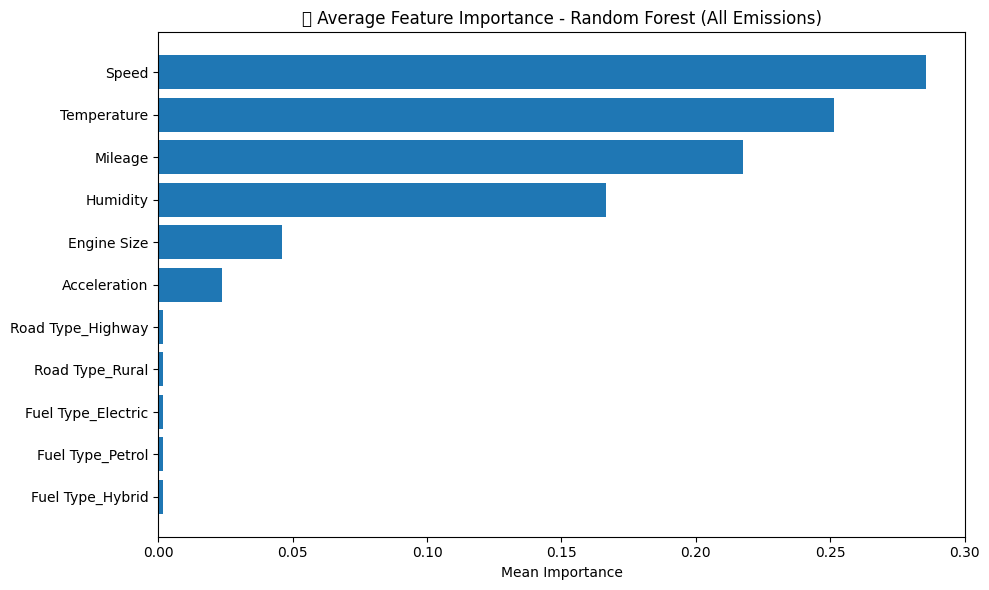

In [7]:
# --- Average feature importance across all emission regressors ---
import numpy as np
import matplotlib.pyplot as plt

feature_names = (
    list(numeric_features) +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Get mean importance across all sub-models
importances = np.mean(
    [est.feature_importances_ for est in model.estimators_],
    axis=0
)

# Sort by importance
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.title("🌳 Average Feature Importance - Random Forest (All Emissions)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()
